#### Montar pasta do Google Drive ####

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Imports e pip ####

In [49]:
!pip install transformers
!pip install imbalanced-learn
!pip install pandas
!pip install nltk
!pip install xgboost
!pip install wordcloud

     -------------------------------------- 220.7/220.7 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for wordcloud, since package 'wheel' is not installed.
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'error'


  error: subprocess-exited-with-error
  
  Running setup.py install for wordcloud did not run successfully.
  exit code: 1
  
  [20 lines of output]
  running install
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.10
  creating build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\color_from_image.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\tokenization.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\wordcloud.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\wordcloud_cli.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\_version.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\__init__.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\__main__.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\stopwords -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\DroidSansMono.ttf -> build\lib.win-amd64-3.10\wordcloud
  UPDATING build\lib.win-amd64-3.10\wordcloud/_

In [42]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re

from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# from sklearn.feature_extraction.text import 
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from sklearn.ensemble import 
# from sklearn.ensemble import 

from xgboost.sklearn import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import svm, metrics
# from sklearn import 
from matplotlib import pyplot
from scipy.stats import loguniform
from IPython.display import display
# from mlxtend.evaluate import confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from matplotlib import pyplot as plt

In [3]:
# termos muito frequentes que não tem relevância nos dados. São palavras que possuem apenas significado sintático dentro da sentença, porém não trazem informações relevantes sobre o seu sentido.
nltk.download('stopwords')
# RSLP Stemmer (Removedor de Sufixos da Lingua Portuguesa)
nltk.download('rslp')
# punkt é um tokenizer 
nltk.download('punkt')
# dicionário de léxicos (conjunto de vocabulários de determinado idioma) e hierarquia de termos
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Carregar os dados nos dataframes ####

In [71]:
df_teste = pd.read_csv('../dataset/test_translated.csv', sep=';', encoding='utf-8')
df_treino = pd.read_csv('../dataset/train_translated.csv', sep=';', encoding='utf-8')
df_validacao = pd.read_csv('../dataset/val_translated.csv', sep=';', encoding='utf-8')
df_text_emotion = pd.read_csv('../dataset/text_to_emotion_translated.csv', sep=';', encoding='utf-8')
df = pd.concat([df_treino[['texto', 'emocao']], df_teste[['texto', 'emocao']], df_validacao[['texto', 'emocao']], df_text_emotion[['texto', 'emocao']]], ignore_index=True)

#### Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)

In [72]:
df.count()

texto     49995
emocao    49995
dtype: int64

In [73]:
df.head(3)

,texto,emocao
0,eu não me senti humilhado,tristeza
1,eu posso passar de me sentindo tão sem esperan...,tristeza
2,estou pegando um minuto para postar me sinto g...,raiva


In [74]:
df.nunique()

texto     44427
emocao       14
dtype: int64

In [75]:
print(df['emocao'].unique())

['tristeza' 'raiva' 'amar' 'surpresa' 'medo' 'alegria' 'temer'
 'sentimento' 'RAIVA' 'TEMER' 'ALEGRIA' 'AMAR' 'TRISTEZA' 'SURPRESA' nan]


In [76]:
df['texto'] = df['texto'].str.lower()
df['emocao'] = df['emocao'].str.lower()

In [77]:
print(df['emocao'].unique())

['tristeza' 'raiva' 'amar' 'surpresa' 'medo' 'alegria' 'temer'
 'sentimento' nan]


<AxesSubplot:>

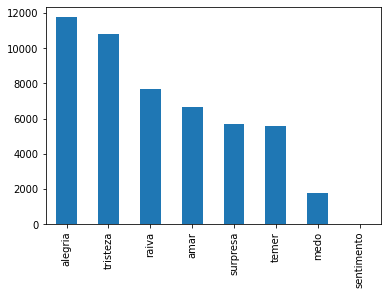

In [78]:
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

#### Feature Engineer:

* Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)
* Remover valores nulos/NAN
* Remover linhas duplicadas

In [79]:
df.isna().sum()

texto     3
emocao    3
dtype: int64

In [80]:
df = df.dropna()

In [81]:
df.isna().sum()

texto     0
emocao    0
dtype: int64

In [82]:
df.count()

texto     49995
emocao    49995
dtype: int64

In [83]:
df = df.drop_duplicates(['texto'])

In [84]:
df.count()

texto     44408
emocao    44408
dtype: int64

In [85]:
df['tamanho_texto'] = df['texto'].apply(lambda x: len(x))

In [86]:
df['tamanho_texto'].describe()

count    44408.000000
mean       107.709850
std         62.078965
min          5.000000
25%         61.000000
50%         95.000000
75%        141.000000
max        875.000000
Name: tamanho_texto, dtype: float64

#### Defini funções para pre processamento

In [87]:
pontuacao = list(string.punctuation)

In [88]:
def exclui_palavras_irrelevantes(texto):
    #stops = set(stopwords.words('portuguese') + pontuacao)
    stops = set(stopwords.words('portuguese'))
    palavras = [i for i in texto.split() if not i in stops]
    return (" ".join(palavras))

In [89]:
def exclui_radicais(texto):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in texto.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [90]:
def exclui_pontuacao(texto):
    palavras = [i for i in texto if not i in pontuacao]
    return ("".join(palavras))

In [91]:
def lemmatization(instancia):
    wordnet_lemmatizer = WordNetLemmatizer()
    palavras = []
    for w in instancia.split():
        palavras.append(wordnet_lemmatizer.lemmatize(w))
    return (" ".join(palavras))


#### Aplica as funções de pre-processamento nos dados e split Train / Test dataset

* Avaliar o uso do Stemming (remove o radical das palavras (Ex. altera frequentemente para frenquent, imediatamente para imediat), isso pode trazer um problema pois ele pode gerar palavras que não existem no idioma.
* Avaliar o uso do Lemmatization (Ex. uma forma de Stemming que mantém a palavra com significado real (Ex. altera frequentemente para frenquente, imediatamente para imediato). O problema dessa abordagem, é que o Lemmatizer do NLTK utiliza o Dicionário da WordNet que não é específico para o Portugues

In [92]:
def pre_processing(texto, show_results=False):
    stemmer = exclui_radicais(texto.lower())
    pont = exclui_pontuacao(stemmer)
    stops = exclui_palavras_irrelevantes(pont)
    lemma = lemmatization(stops)
    if(show_results):
        print('Original text: {}'.format(texto))
        print('Stemmer aplicado: {}'.format(stemmer))
        print('Exclusao de pontuação aplicado: {}'.format(pont))
        print('Exclusao de stopwords aplicado: {}'.format(stops))
    return ("".join(lemma))

In [93]:
# Analise sobre possível desbalanceamento de classes
df['emocao'].value_counts()

alegria       11086
tristeza       9893
raiva          7206
amar           5945
temer          4821
surpresa       3692
medo           1764
sentimento        1
Name: emocao, dtype: int64

<AxesSubplot:>

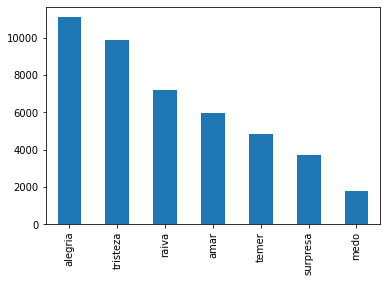

In [99]:
# Analise sobre possível desbalanceamento de classes
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

In [101]:
df = df.drop(df[df['emocao'] == 'sentimento'].index)

In [102]:
# aplicando os processos de tratamento nos texto (retirada de pontuação, stopwords, stemmer e lemmatization)
X = [pre_processing(i) for i in df['texto']]

In [103]:
labelencoder = LabelEncoder()
df['emocao_encoded'] = labelencoder.fit_transform(df['emocao'])

X_train, X_test, y_train, y_test = train_test_split(pd.Series(X), df['emocao_encoded'], random_state=41, test_size=0.2, stratify=df['emocao_encoded'])

# Com o uso do Undersampler a performce do modelo piora, muito provavelmente devido a grande diminuição de dados
# undersample = RandomUnderSampler()
# X_under, y_under = undersample.fit_resample(pd.DataFrame(X), df['emocao_encoded'])
# X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under.squeeze(), y_under, random_state=41, test_size=0.2, stratify=y_under)

In [104]:
type(df['emocao_encoded'])
# X_test

pandas.core.series.Series

In [108]:
df[['emocao','emocao_encoded']].drop_duplicates()

,emocao,emocao_encoded
0,tristeza,6
2,raiva,3
3,amar,1
6,surpresa,4
7,medo,2
8,alegria,0
19,temer,5


<AxesSubplot:>

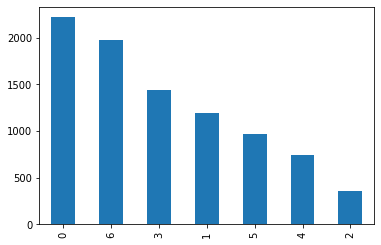

In [109]:
# analisando o resultado da aplicação de undersampler nas classes para ficarem próximas ao da classe minoritária
%matplotlib inline
y_test.value_counts().plot(kind='bar')

#### Tokenização - Importante. Por não se tratar de uma análise de dados recuperados da internet, onde existe um linguajar específico onde é usado emoticons, hashtag, emojis e etc, para essa análise não precisamos utilizar o Tokenizer do Tweeter para tratar esse tipo de linguajar. Podemos usar o Tokenizer de palavras normais e entender que o espaço é o suficiente para separar as palavras sem afetar o sentido do textos

#### Frases e Predições de teste

In [110]:
testes = ['eu posso ter para um deleite ou se estou me sentindo festivo',
          'estou me sentindo muito triste e com pena de mim mesma, mas logo vou me livrar disso',
          'estou apenas me sentindo mal-humorada e azul ',
          'só sei que, para começar, vou me sentir tímido com isso',
          'eu também adorei que você pudesse realmente sentir o desespero nessas sequências e eu gostei especialmente da emoção entre cavaleiro e escudeiro, já que eles estão juntos de maneira semelhante a batman e robin há muito tempo',
          'estou me sentindo um pouco atordoada com a quantidade de itens que não uso mais para decoração']

predicao_correta = ['alegria', 'tristeza', 'raiva', 'medo', 'amar', 'surpresa']

In [111]:
testes = [pre_processing(i) for i in testes]

In [112]:
# Transforma os dados de teste em vetores de palavras.
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
texto_teste_vetorizado = tfidf_vectorizer.transform(testes)

#### Vetorização dos textos

*   CountVectorizer: [BagOfWords Model] - É uma representação numérica de uma fração do texto que facilita a classificação, dessa forma o algoritmo conta a frequnência com que a palavra aparece no texto e cria um dicionário disso. Isso é chamado de Tokenization in NLP (Natural Language Processing). O CountVectorizer realiza esse processo
*   TfidfVectorizer: Transforma texto em vetores de recursos que podem ser usados ​​como entrada para o estimador

In [113]:
# Bag of Words
vec = CountVectorizer(min_df=2, max_df=.85, max_features=10000)
bow = vec.fit_transform(df['texto'])
bow_alegria = vec.fit_transform(df['texto'].loc[df['emocao'] == 'alegria'])
bow_tristeza = vec.fit_transform(df['texto'].loc[df['emocao'] == 'tristeza'])
bow_raiva = vec.fit_transform(df['texto'].loc[df['emocao'] == 'raiva'])
bow_amar = vec.fit_transform(df['texto'].loc[df['emocao'] == 'amar'])
bow_surpresa = vec.fit_transform(df['texto'].loc[df['emocao'] == 'surpresa'])
bow_medo = vec.fit_transform(df['texto'].loc[df['emocao'] == 'medo'])

feature_names = vec.get_feature_names()
feature_names_alegria = vec.get_feature_names()
feature_names_tristeza = vec.get_feature_names()
feature_names_raiva = vec.get_feature_names()
feature_names_amar = vec.get_feature_names()
feature_names_surpresa = vec.get_feature_names()
feature_names_medo = vec.get_feature_names()

tfidf_transformer = TfidfTransformer().fit(bow)
tfidf_vec = tfidf_transformer.transform(bow)

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [114]:
tfidf_vec

<44407x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 698698 stored elements in Compressed Sparse Row format>

In [115]:
# # Nuvem de palavras para os textos
# !pip install wordcloud
# from wordcloud import WordCloud

# def generate_word_cloud(feature_name):
#     texto = ' '.join(features_name)
#     wordcloud = WordCloud(max_font_size=100, width=1520, height=535, colormap='viridis', background_color='white').generate(texto)
#     plt.figure(figsize=(16,9))
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.show()

In [116]:
list_features_names = [
    feature_names_alegria
    ,feature_names_tristeza
    ,feature_names_raiva
    ,feature_names_amar
    ,feature_names_surpresa
    ,feature_names_medo
]

In [117]:
# for f in list_features_names:
#     generate_word_cloud(f)

In [118]:
def get_vectorize_instance(vectorize_name):
    if(vectorize_name == 'CountVectorizer'):
        return CountVectorizer(analyzer="word")
    elif(vectorize_name == 'TfidfVectorizer'):
        return TfidfVectorizer(analyzer="word")
    else:
        raise Exception("Vectorizer not found!")

In [119]:
def vectorize_dataframe(vectorizer, X_train, X_test):
    if(type(vectorizer) is CountVectorizer):
        train_data = vectorizer.fit_transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    elif (type(vectorizer) is TfidfVectorizer):
        vectorizer.fit(X_train)
        train_data = vectorizer.transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    else:
        raise Exception("Vectorizer type incorrect!")

In [120]:
def train_model(modelo, X_train, y_train):
    return modelo.fit(X_train, y_train)

In [121]:
def predict_model(modelo, X_test):
    return modelo.predict(X_test)

In [122]:
def score_model(modelo, X_test, y_test):
    return modelo.score(X_test, y_test)

In [123]:
def plot_predict_right(X_test, predictions, right_predictions, num_rows=5):
    pred = pd.DataFrame({'predição modelo': predictions, 'predição correta': right_predictions})
    display(pred[:num_rows])

In [124]:
def plot_classification_report(y_test, y_pred):
    print(metrics.classification_report(y_test, y_pred))

In [125]:
def plot_confusion_matrix_graph(y_test, y_pred):
    cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=False, show_normed=True, figsize=(10, 10))
    plt.show()

In [126]:
def evaluates_score_model(modelo, vectorizer, X_train, X_test, y_train, y_test):
    print('#######################################################################################################################################')
    print('##### Avaliando Modelo {} / Vectorizer {} #####'.format(modelo, vectorizer))
    train_vectorized, test_vectorized = vectorize_dataframe(vectorizer, X_train, X_test)
    model = train_model(modelo, train_vectorized, y_train)
    y_pred = predict_model(modelo, test_vectorized)
    acc_model = float(metrics.accuracy_score(y_test, y_pred))
    print('Accuracy do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, acc_model))
    print('Precision do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.precision_score(y_test, y_pred, average='macro'))))
    print('Recall do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.recall_score(y_test, y_pred, average='macro'))))
    print('F1-Score do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.f1_score(y_test, y_pred, average='macro'))))
    plot_predict_right(X_test, y_pred, y_test)
    plot_classification_report(y_test, y_pred)
#     plot_confusion_matrix_graph(y_test, y_pred)
    print('\n')
    return modelo, vectorizer, y_pred, acc_model

In [127]:
# 'XGBClassifier': XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', nthread=4, num_class=6, seed=27)),

classifiers = {
        'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'MultinomialNB': MultinomialNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
        'SVC': SVC(kernel='linear'),
        'SGDClassifier': SGDClassifier(loss="log", penalty="l2"),
        'DecisionTreeClassifier': DecisionTreeClassifier(criterion="gini"),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
        'AdaBoostClassifier': AdaBoostClassifier(),
        'XGBClassifier': XGBClassifier(objective='multi:softmax', num_class=6),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150),
    }

In [128]:
def get_model_instace(model):
    return classifiers.get(model) 

In [129]:
list_models = [get_model_instace('LogisticRegression')
                ,get_model_instace('MultinomialNB')
                ,get_model_instace('RandomForestClassifier')
                ,get_model_instace('SVC')
                ,get_model_instace('SGDClassifier')
                ,get_model_instace('DecisionTreeClassifier')
                ,get_model_instace('KNeighborsClassifier')
                ,get_model_instace('AdaBoostClassifier')
                ,get_model_instace('XGBClassifier')
                ,get_model_instace('GradientBoostingClassifier')]

list_vectors_instance = [get_vectorize_instance('CountVectorizer'), get_vectorize_instance('TfidfVectorizer')]

In [134]:
def evaluates_all_models(list_models, list_vectors_instance):
    modelos = []
    vectorizers = []
    y_predictions = []
    accs = []
    for m in list_models:
        for vec in list_vectors_instance:
            modelo, vec, y_pred, acc = evaluates_score_model(m, vec, X_train, X_test, y_train, y_test)
            modelos.append(modelo), y_predictions.append(y_pred), vectorizers.append(vec), accs.append(acc)
#             d[modelo] = y_pred
    print('##### Fim avaliação #####')
    return modelos, vectorizers, y_predictions, accs

In [131]:
def plot_all_confusion_matrix(modelos, vectorizers, y_test, y_predictions):
    '''
    Método responsável por plotar a matriz de confusão dos modelos passados via parametro
    '''
    cols = 4
    rows = 5 
    
    f, axes = plt.subplots(rows, cols, figsize=(70, 60), sharey='row')

    idx_col = 0
    idx_row = 0

    font = {'family' : 'monospace', 'weight' : 'bold', 'size' : 40}
    
    for m, v, y in zip(modelos, vectorizers, y_predictions):

        cm = confusion_matrix(y_test, y, labels = m.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = m.classes_)
        
        if(idx_col == cols):
            idx_row = idx_row + 1
            idx_col = 0
            disp.plot(ax=axes[idx_row, idx_col], xticks_rotation=5)
            idx_col = idx_col + 1
        else:
            disp.plot(ax=axes[idx_row, idx_col], xticks_rotation=5)
            idx_col = idx_col + 1

        disp.ax_.set_title('{}-{}'.format(str(type(m).__name__), str(v)[0:5]))
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('Predita')
        disp.ax_.set_ylabel('Verdadeira')

    f.text(0.4, 1.0, 'Matriz de confusão dos modelos', fontsize="x-large")
    plt.subplots_adjust(wspace=0.9, hspace=.40)
    plt.rc('font', **font)
    plt.rc('figure', figsize=(30, 20))
    plt.show()

In [132]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = loguniform(1e-5, 100)

# search = RandomizedSearchCV(LogisticRegression(), space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# # search = GridSearchCV(..., scoring='accuracy', n_jobs=-1)

# train_vectorized, test_vectorized = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, X_test)

# # execute search
# result = search.fit(train_vectorized, y_train)

# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

In [135]:
# executa o método que fará a avaliação dos modelos
modelos, vectorizers, y_predictions, accs = evaluates_all_models(list_models, list_vectors_instance)

#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer CountVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.806
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.785
Recall do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.759
F1-Score do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.769


C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2217
           1       0.84      0.79      0.82      1189
           2       0.57      0.39      0.46       353
           3       0.79      0.80      0.80      1441
           4       0.88      0.89      0.88       739
           5       0.81      0.77      0.79       964
           6       0.81      0.82      0.81      1979

    accuracy                           0.81      8882
   macro avg       0.78      0.76      0.77      8882
weighted avg       0.80      0.81      0.80      8882



#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 0.805
Precision do Modelo LogisticRegression(multi_class

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.77      0.88      0.82      2217
           1       0.86      0.77      0.81      1189
           2       0.57      0.28      0.38       353
           3       0.79      0.82      0.81      1441
           4       0.90      0.87      0.88       739
           5       0.84      0.75      0.79       964
           6       0.81      0.82      0.81      1979

    accuracy                           0.81      8882
   macro avg       0.79      0.74      0.76      8882
weighted avg       0.80      0.81      0.80      8882



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer CountVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.748
Precision do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.737
Recall do Modelo MultinomialNB

,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.72      0.86      0.79      2217
           1       0.82      0.68      0.74      1189
           2       0.46      0.03      0.06       353
           3       0.75      0.75      0.75      1441
           4       0.91      0.70      0.79       739
           5       0.80      0.69      0.74       964
           6       0.69      0.83      0.75      1979

    accuracy                           0.75      8882
   macro avg       0.74      0.65      0.66      8882
weighted avg       0.75      0.75      0.74      8882



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.629
Precision do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.811
Recall do Modelo MultinomialNB

,predição modelo,predição correta
7078,0,2
29275,3,5
41252,6,6
45468,0,4
26280,5,5


              precision    recall  f1-score   support

           0       0.54      0.94      0.69      2217
           1       0.93      0.44      0.60      1189
           2       1.00      0.00      0.01       353
           3       0.83      0.57      0.68      1441
           4       0.94      0.16      0.27       739
           5       0.87      0.36      0.51       964
           6       0.57      0.86      0.69      1979

    accuracy                           0.63      8882
   macro avg       0.81      0.48      0.49      8882
weighted avg       0.73      0.63      0.59      8882



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.794
Precision do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.778
Rec

,predição modelo,predição correta
7078,0,2
29275,3,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2217
           1       0.86      0.78      0.82      1189
           2       0.54      0.32      0.40       353
           3       0.79      0.80      0.79      1441
           4       0.87      0.88      0.88       739
           5       0.84      0.73      0.78       964
           6       0.79      0.81      0.80      1979

    accuracy                           0.79      8882
   macro avg       0.78      0.74      0.75      8882
weighted avg       0.79      0.79      0.79      8882



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.786
Precision do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.778
Rec

,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.73      0.87      0.79      2217
           1       0.87      0.76      0.81      1189
           2       0.57      0.26      0.36       353
           3       0.77      0.81      0.79      1441
           4       0.88      0.87      0.87       739
           5       0.84      0.73      0.78       964
           6       0.80      0.78      0.79      1979

    accuracy                           0.79      8882
   macro avg       0.78      0.73      0.74      8882
weighted avg       0.79      0.79      0.78      8882



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.792
Precision do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.767
Recall do Model

,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.77      0.85      0.81      2217
           1       0.81      0.79      0.80      1189
           2       0.50      0.44      0.47       353
           3       0.79      0.78      0.78      1441
           4       0.87      0.89      0.88       739
           5       0.82      0.74      0.78       964
           6       0.82      0.79      0.80      1979

    accuracy                           0.79      8882
   macro avg       0.77      0.75      0.76      8882
weighted avg       0.79      0.79      0.79      8882



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.807
Precision do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.790
Recall do Model

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,1,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2217
           1       0.86      0.78      0.82      1189
           2       0.59      0.39      0.47       353
           3       0.78      0.82      0.80      1441
           4       0.87      0.92      0.89       739
           5       0.83      0.76      0.79       964
           6       0.82      0.80      0.81      1979

    accuracy                           0.81      8882
   macro avg       0.79      0.76      0.77      8882
weighted avg       0.81      0.81      0.80      8882



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.807
Precision do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.793


,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2217
           1       0.83      0.80      0.81      1189
           2       0.61      0.33      0.43       353
           3       0.79      0.82      0.80      1441
           4       0.88      0.90      0.89       739
           5       0.83      0.76      0.80       964
           6       0.83      0.81      0.82      1979

    accuracy                           0.81      8882
   macro avg       0.79      0.75      0.77      8882
weighted avg       0.81      0.81      0.80      8882



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.770
Precision do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.778


,predição modelo,predição correta
7078,0,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2217
           1       0.88      0.70      0.78      1189
           2       0.58      0.11      0.19       353
           3       0.79      0.77      0.78      1441
           4       0.91      0.80      0.85       739
           5       0.84      0.68      0.75       964
           6       0.76      0.82      0.79      1979

    accuracy                           0.77      8882
   macro avg       0.78      0.68      0.70      8882
weighted avg       0.78      0.77      0.76      8882



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.738
Precision do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.714
Rec

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2217
           1       0.79      0.77      0.78      1189
           2       0.43      0.39      0.41       353
           3       0.73      0.76      0.75      1441
           4       0.84      0.82      0.83       739
           5       0.74      0.69      0.71       964
           6       0.72      0.72      0.72      1979

    accuracy                           0.74      8882
   macro avg       0.71      0.70      0.71      8882
weighted avg       0.74      0.74      0.74      8882



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.726
Precision do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.700
Rec

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.72      0.76      0.74      2217
           1       0.79      0.77      0.78      1189
           2       0.39      0.34      0.36       353
           3       0.72      0.73      0.73      1441
           4       0.85      0.82      0.83       739
           5       0.73      0.69      0.71       964
           6       0.71      0.71      0.71      1979

    accuracy                           0.73      8882
   macro avg       0.70      0.69      0.69      8882
weighted avg       0.72      0.73      0.72      8882



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.572
Precision do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.559
Recall do

,predição modelo,predição correta
7078,0,2
29275,6,5
41252,1,6
45468,6,4
26280,5,5


              precision    recall  f1-score   support

           0       0.52      0.69      0.60      2217
           1       0.65      0.57      0.60      1189
           2       0.25      0.13      0.17       353
           3       0.59      0.53      0.56      1441
           4       0.72      0.57      0.64       739
           5       0.63      0.53      0.58       964
           6       0.55      0.57      0.56      1979

    accuracy                           0.57      8882
   macro avg       0.56      0.51      0.53      8882
weighted avg       0.57      0.57      0.57      8882



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.666
Precision do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.655
Recall do

,predição modelo,predição correta
7078,0,2
29275,3,5
41252,1,6
45468,0,4
26280,5,5


              precision    recall  f1-score   support

           0       0.62      0.80      0.70      2217
           1       0.68      0.63      0.65      1189
           2       0.46      0.32      0.37       353
           3       0.70      0.64      0.67      1441
           4       0.76      0.61      0.68       739
           5       0.67      0.56      0.61       964
           6       0.69      0.69      0.69      1979

    accuracy                           0.67      8882
   macro avg       0.65      0.61      0.63      8882
weighted avg       0.67      0.67      0.66      8882



#######################################################################################################################################
##### Avaliando Modelo AdaBoostClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo AdaBoostClassifier() com Vectorizer CountVectorizer() é de 0.526
Precision do Modelo AdaBoostClassifier() com Vectorizer CountVectorizer() é de 0.668
Recall do Model

,predição modelo,predição correta
7078,0,2
29275,0,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.36      0.96      0.52      2217
           1       0.98      0.45      0.61      1189
           2       0.00      0.00      0.00       353
           3       0.89      0.35      0.50      1441
           4       0.91      0.73      0.81       739
           5       0.79      0.65      0.71       964
           6       0.74      0.18      0.28      1979

    accuracy                           0.53      8882
   macro avg       0.67      0.47      0.49      8882
weighted avg       0.69      0.53      0.50      8882



#######################################################################################################################################
##### Avaliando Modelo AdaBoostClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo AdaBoostClassifier() com Vectorizer TfidfVectorizer() é de 0.524
Precision do Modelo AdaBoostClassifier() com Vectorizer TfidfVectorizer() é de 0.666
Recall do Model

,predição modelo,predição correta
7078,0,2
29275,0,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.36      0.96      0.52      2217
           1       0.98      0.45      0.61      1189
           2       0.00      0.00      0.00       353
           3       0.90      0.35      0.50      1441
           4       0.91      0.72      0.80       739
           5       0.79      0.65      0.71       964
           6       0.73      0.17      0.28      1979

    accuracy                           0.52      8882
   macro avg       0.67      0.47      0.49      8882
weighted avg       0.69      0.52      0.50      8882



#######################################################################################################################################
##### Avaliando Modelo XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy do Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_class=6, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_par

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2217
           1       0.85      0.81      0.83      1189
           2       0.57      0.44      0.50       353
           3       0.78      0.82      0.80      1441
           4       0.86      0.92      0.88       739
           5       0.85      0.76      0.80       964
           6       0.87      0.76      0.81      1979

    accuracy                           0.80      8882
   macro avg       0.79      0.77      0.77      8882
weighted avg       0.80      0.80      0.80      8882



#######################################################################################################################################
##### Avaliando Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy do Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_class=6, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_par

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.73      0.87      0.79      2217
           1       0.86      0.79      0.82      1189
           2       0.57      0.43      0.49       353
           3       0.79      0.81      0.80      1441
           4       0.87      0.92      0.89       739
           5       0.85      0.74      0.79       964
           6       0.86      0.76      0.81      1979

    accuracy                           0.80      8882
   macro avg       0.79      0.76      0.77      8882
weighted avg       0.80      0.80      0.80      8882



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer CountVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.763
Precision do Modelo GradientBoostingClassifier(n_est

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.62      0.91      0.73      2217
           1       0.86      0.75      0.80      1189
           2       0.56      0.36      0.44       353
           3       0.83      0.69      0.75      1441
           4       0.88      0.92      0.90       739
           5       0.84      0.73      0.78       964
           6       0.89      0.69      0.77      1979

    accuracy                           0.76      8882
   macro avg       0.78      0.72      0.74      8882
weighted avg       0.79      0.76      0.76      8882



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.765
Precision do Modelo GradientBoostingClassifier(n_est

,predição modelo,predição correta
7078,2,2
29275,5,5
41252,6,6
45468,4,4
26280,5,5


              precision    recall  f1-score   support

           0       0.62      0.91      0.73      2217
           1       0.86      0.75      0.80      1189
           2       0.58      0.40      0.47       353
           3       0.83      0.69      0.76      1441
           4       0.88      0.91      0.90       739
           5       0.85      0.73      0.79       964
           6       0.89      0.69      0.78      1979

    accuracy                           0.77      8882
   macro avg       0.79      0.73      0.75      8882
weighted avg       0.79      0.77      0.77      8882



##### Fim avaliação #####


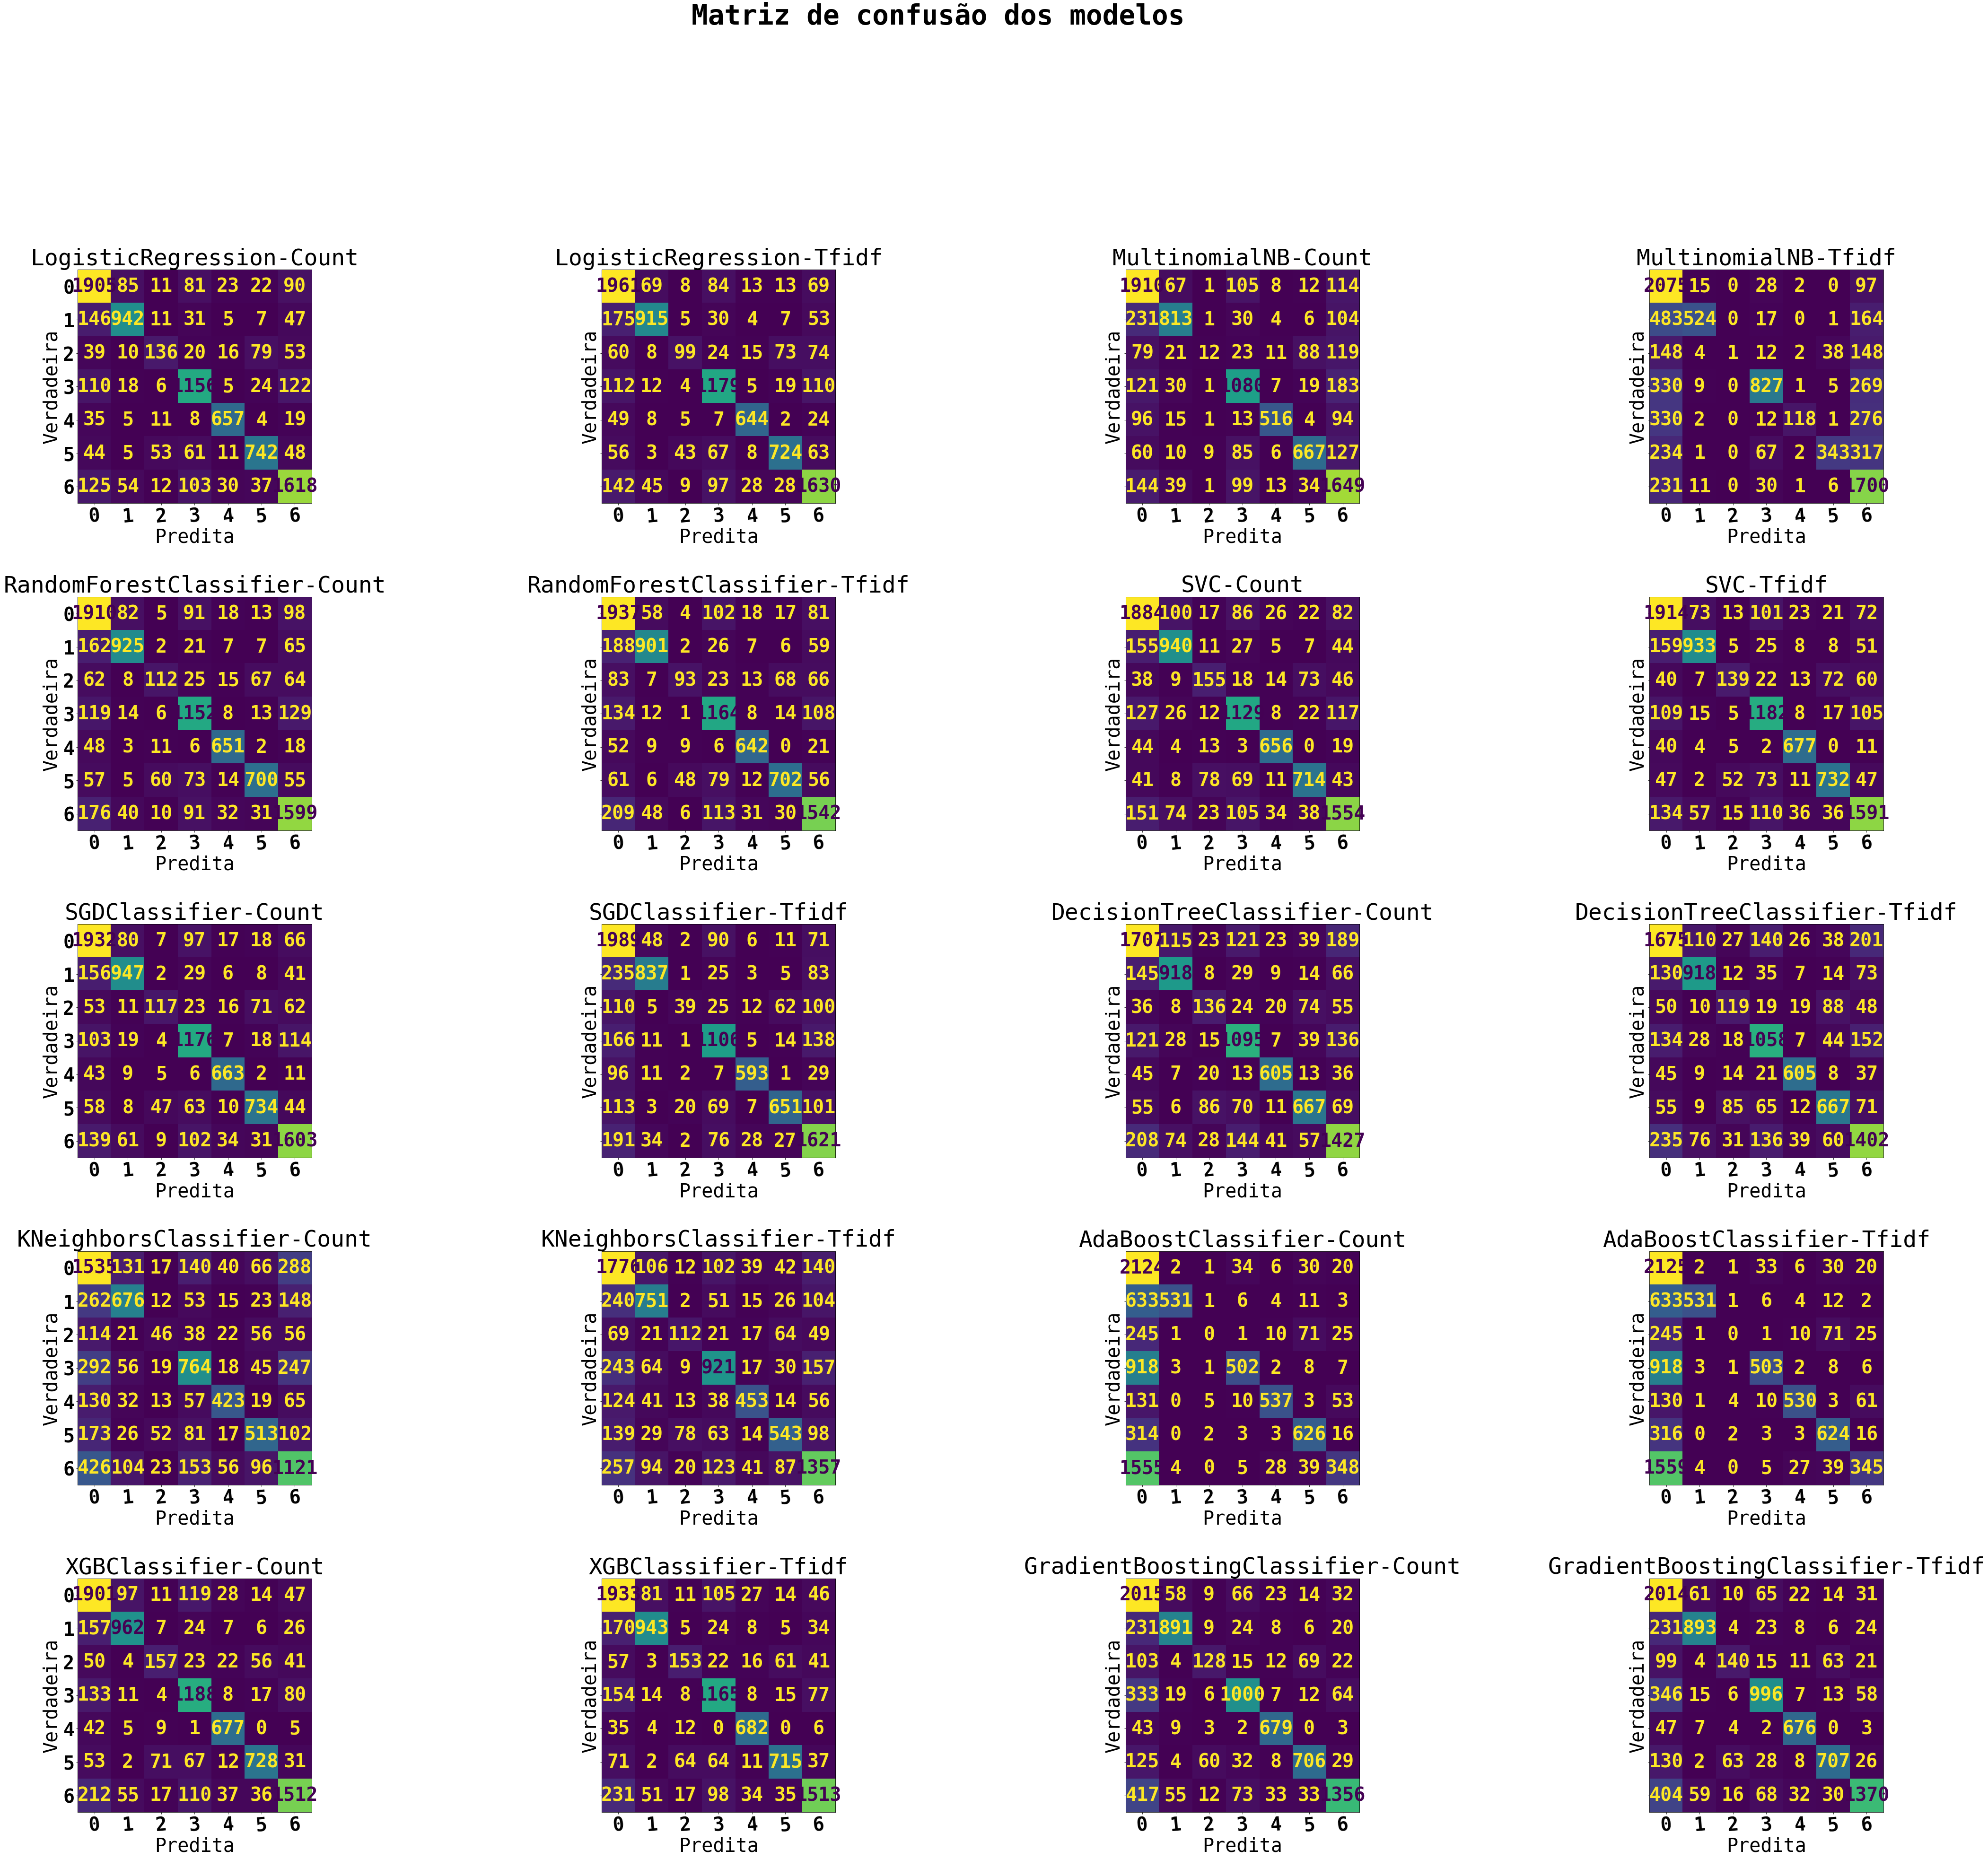

In [138]:
plot_all_confusion_matrix(modelos, vectorizers, y_test, y_predictions)

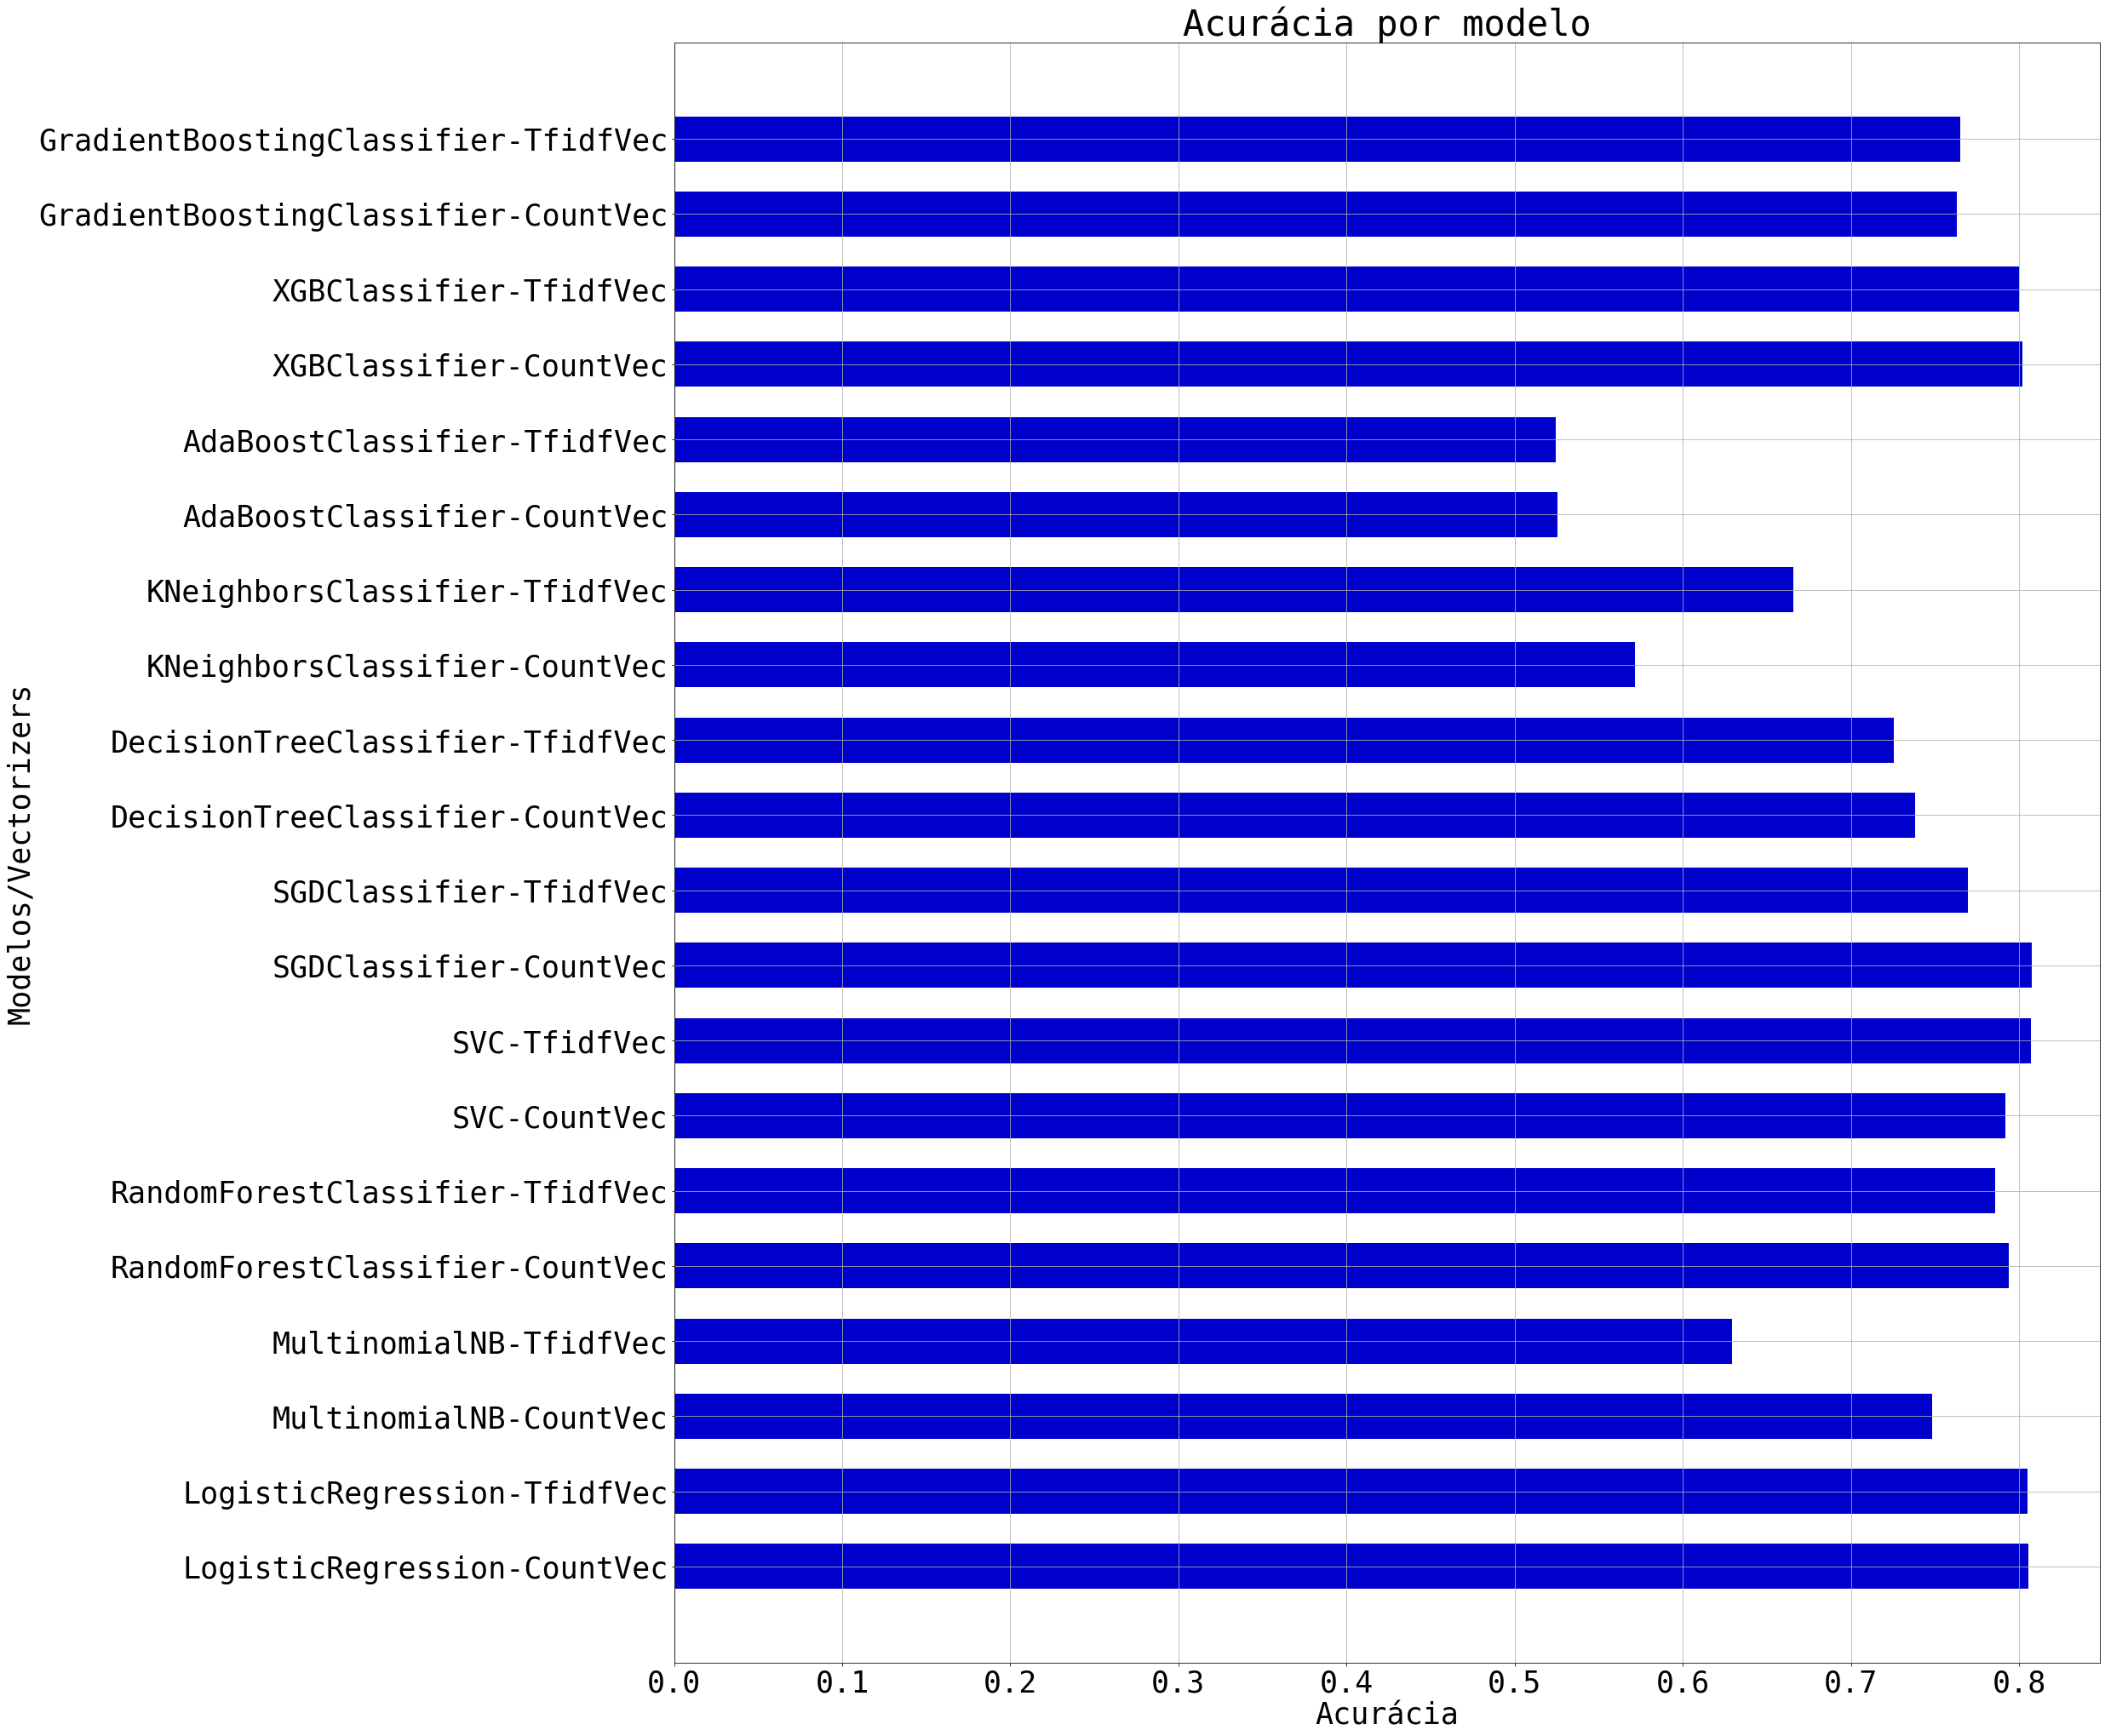

In [139]:
y = np.arange(len(pd.Series(vectorizers)))
width = 0.6
  
labels = []
    
font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 35}
plt.rc('font', **font)
plt.rc('figure', figsize=(30, 35))

for m,v in zip (modelos, vectorizers):
    index_parenteses = str(m).index("(")
    label = ('{}-{}'.format(str(m)[0:index_parenteses], str(v)[:8]))
    labels.append(label)

plt.barh(y, accs, width, color='mediumblue')
plt.yticks(y, labels, rotation='horizontal')

plt.ylabel("Modelos/Vectorizers")
plt.xlabel("Acurácia")
plt.title('Acurácia por modelo')
plt.grid(True)
plt.show()

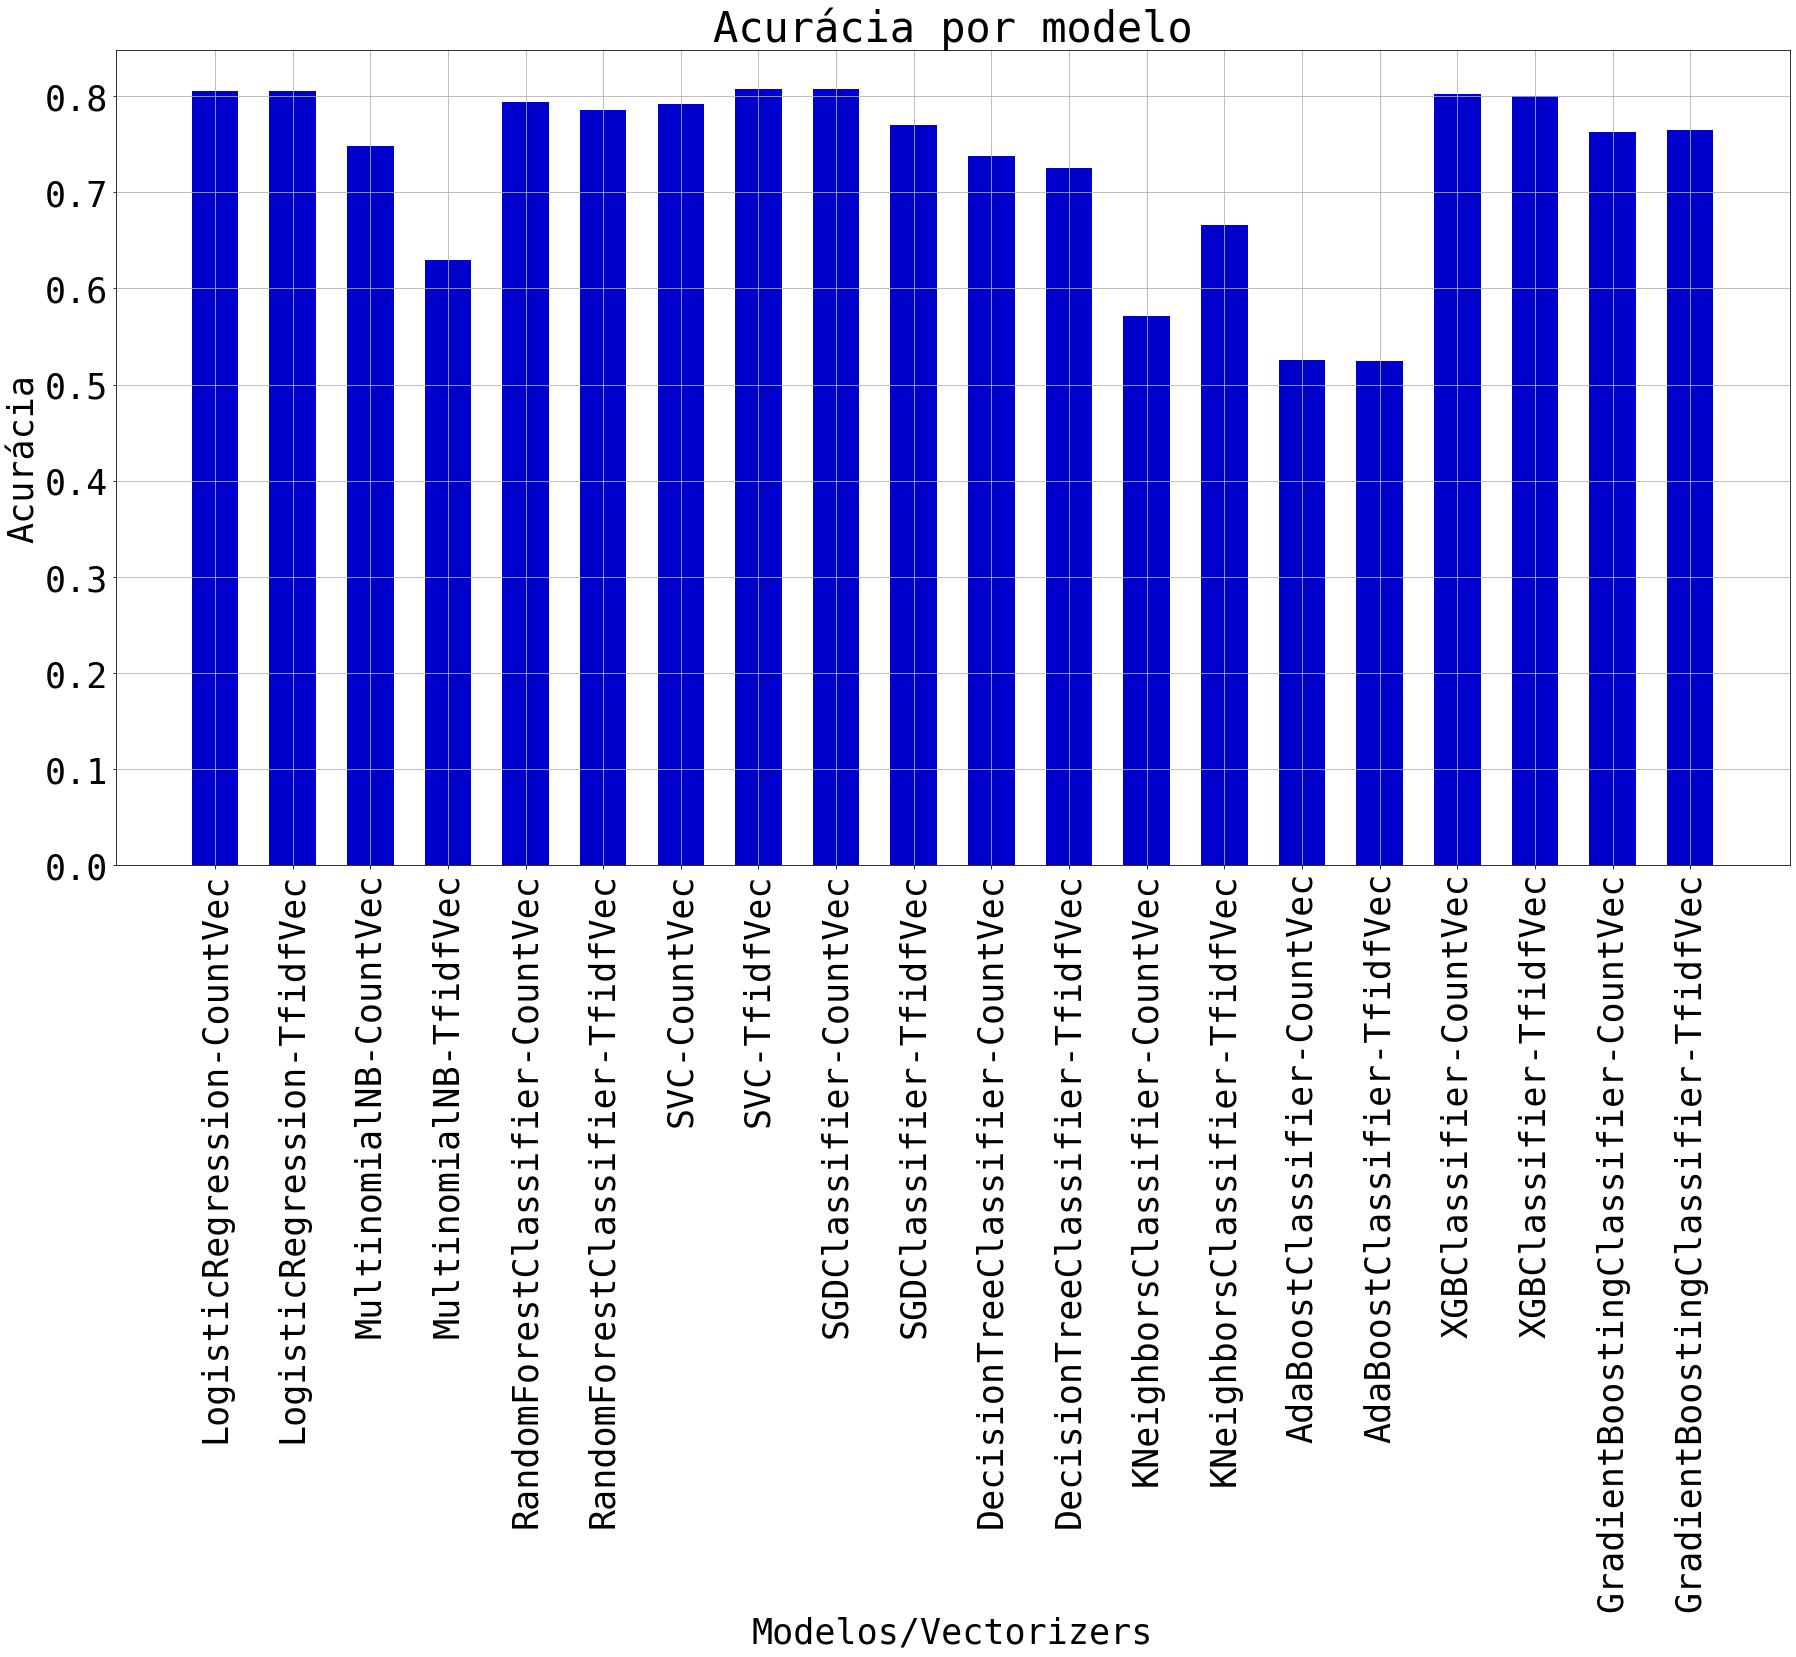

In [140]:
x = np.arange(len(pd.Series(vectorizers)))
width = 0.6
  
labels = []
    
font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 35}
plt.rc('font', **font)
plt.rc('figure', figsize=(30, 15))

for m,v in zip (modelos, vectorizers):
    index_parenteses = str(m).index("(")
    label = ('{}-{}'.format(str(m)[0:index_parenteses], str(v)[:8]))
    labels.append(label)

plt.bar(x, accs, width, color='mediumblue')
plt.xticks(x, labels, rotation='vertical')

plt.xlabel("Modelos/Vectorizers")
plt.ylabel("Acurácia")
plt.title('Acurácia por modelo')
plt.grid(True)
plt.show()

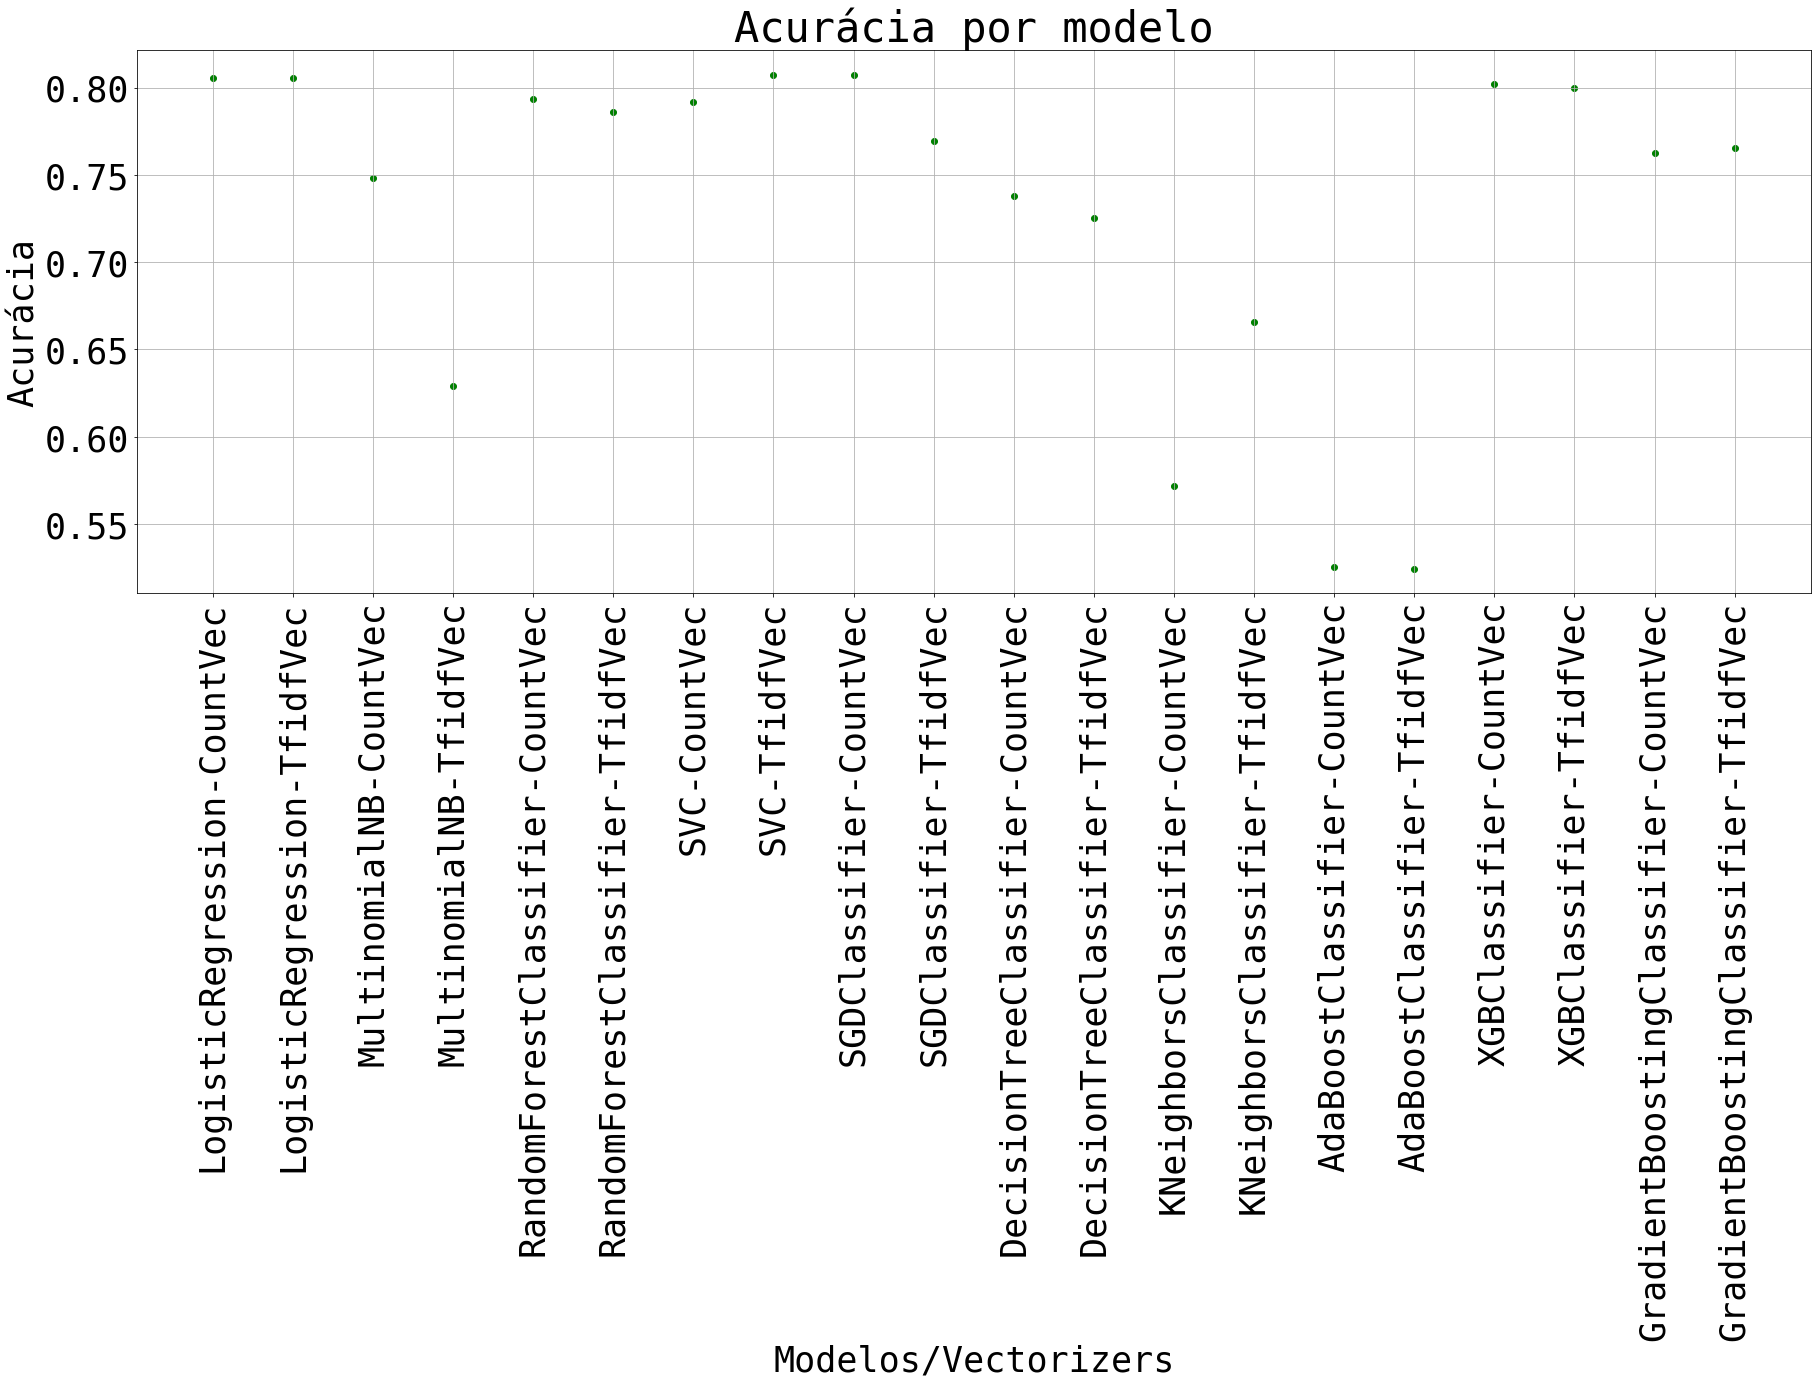

In [141]:
x = np.arange(len(pd.Series(vectorizers)))
  
labels = []
    
font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 35}
plt.rc('font', **font)
plt.rc('figure', figsize=(30, 10))

for m,v in zip (modelos, vectorizers):
    index_parenteses = str(m).index("(")
    label = ('{}-{}'.format(str(m)[0:index_parenteses], str(v)[:8]))
    labels.append(label)

plt.scatter(x, accs, color='green')
plt.xticks(x, labels, rotation='vertical')

plt.xlabel("Modelos/Vectorizers")
plt.ylabel("Acurácia")
plt.title('Acurácia por modelo')
plt.grid(True)
plt.show()

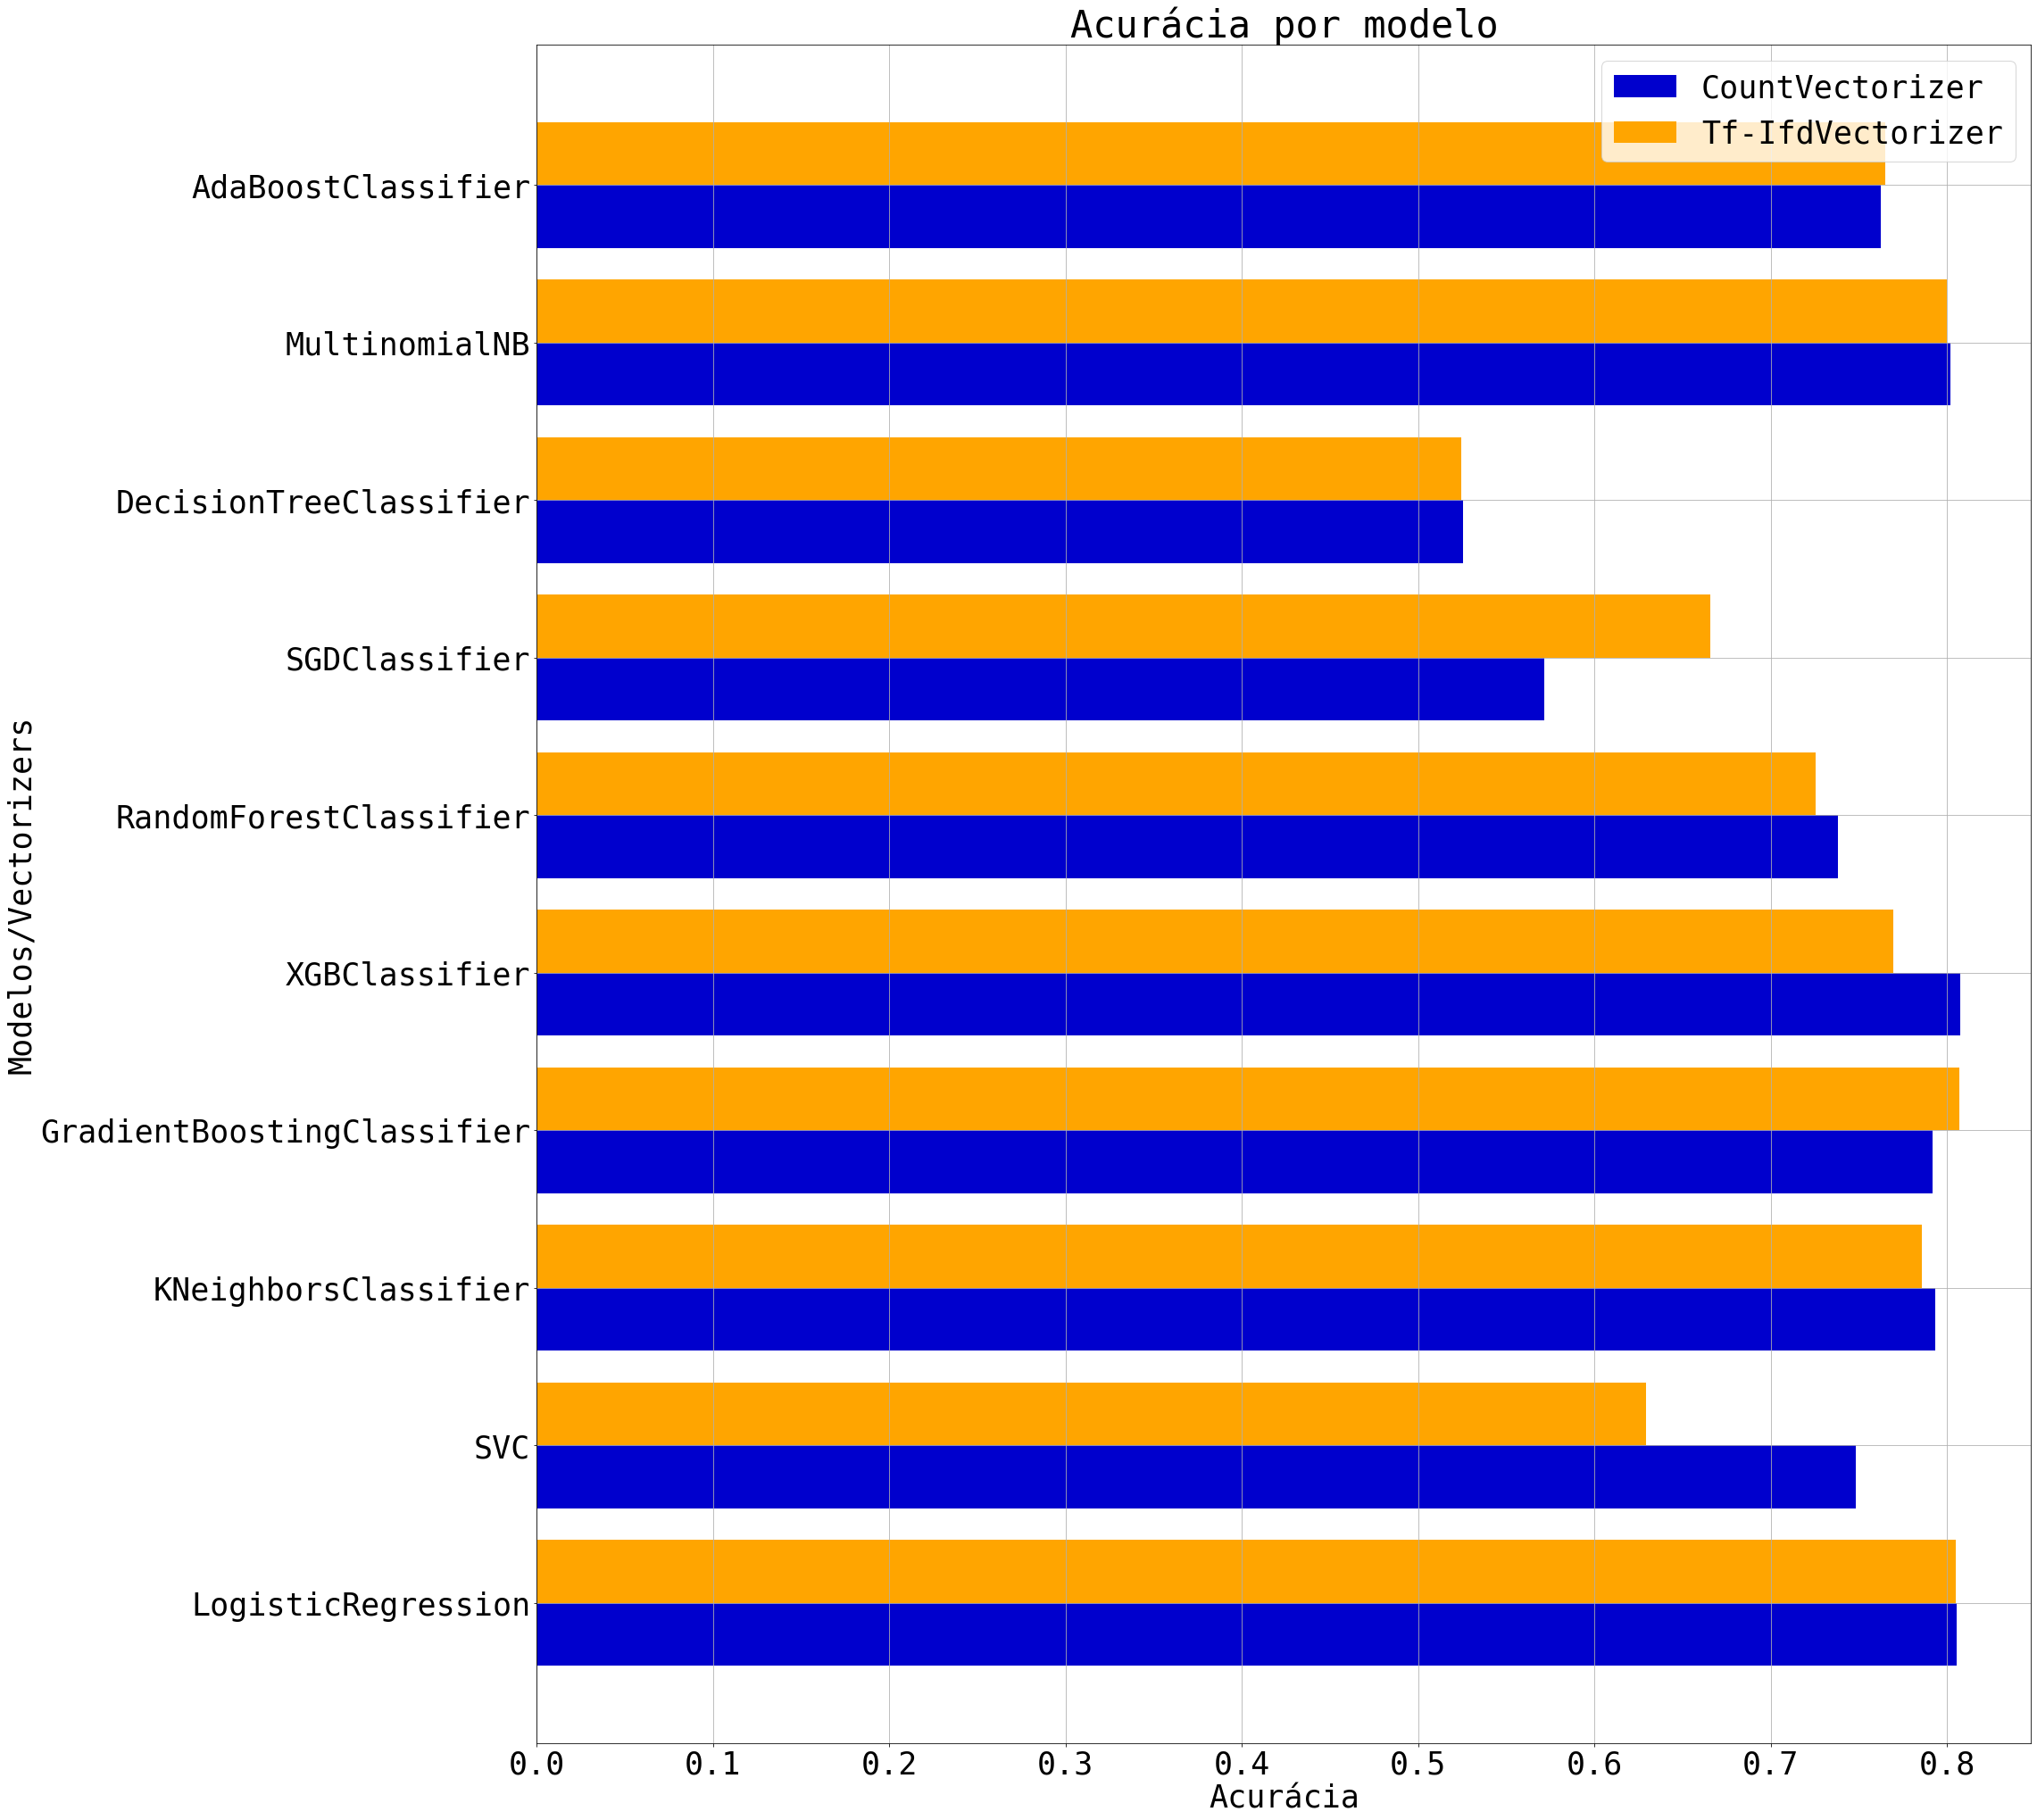

In [142]:
y = np.arange(len(pd.Series(vectorizers))/2)
width = 0.4
  
labels = set()
models_count_vector = []
models_tfidf_vector = []

font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 35}
plt.rc('font', **font)
plt.rc('figure', figsize=(30, 35))

for m,v, a in zip (modelos, vectorizers, accs):
    
    if(str(v) == 'CountVectorizer()'):
        models_count_vector.append(a)
    else:
        models_tfidf_vector.append(a)
    
    index_parenteses = str(m).index("(")
    labels.add(str(m)[0:index_parenteses])

plt.barh(y-0.2, models_count_vector, width, color='mediumblue', label='CountVectorizer')
plt.barh(y+0.2, models_tfidf_vector, width, color='orange', label='Tf-IfdVectorizer')

plt.yticks(y, labels)

plt.ylabel('Modelos/Vectorizers')
plt.xlabel('Acurácia')
plt.title('Acurácia por modelo')
plt.legend()
plt.grid(True)
plt.show()

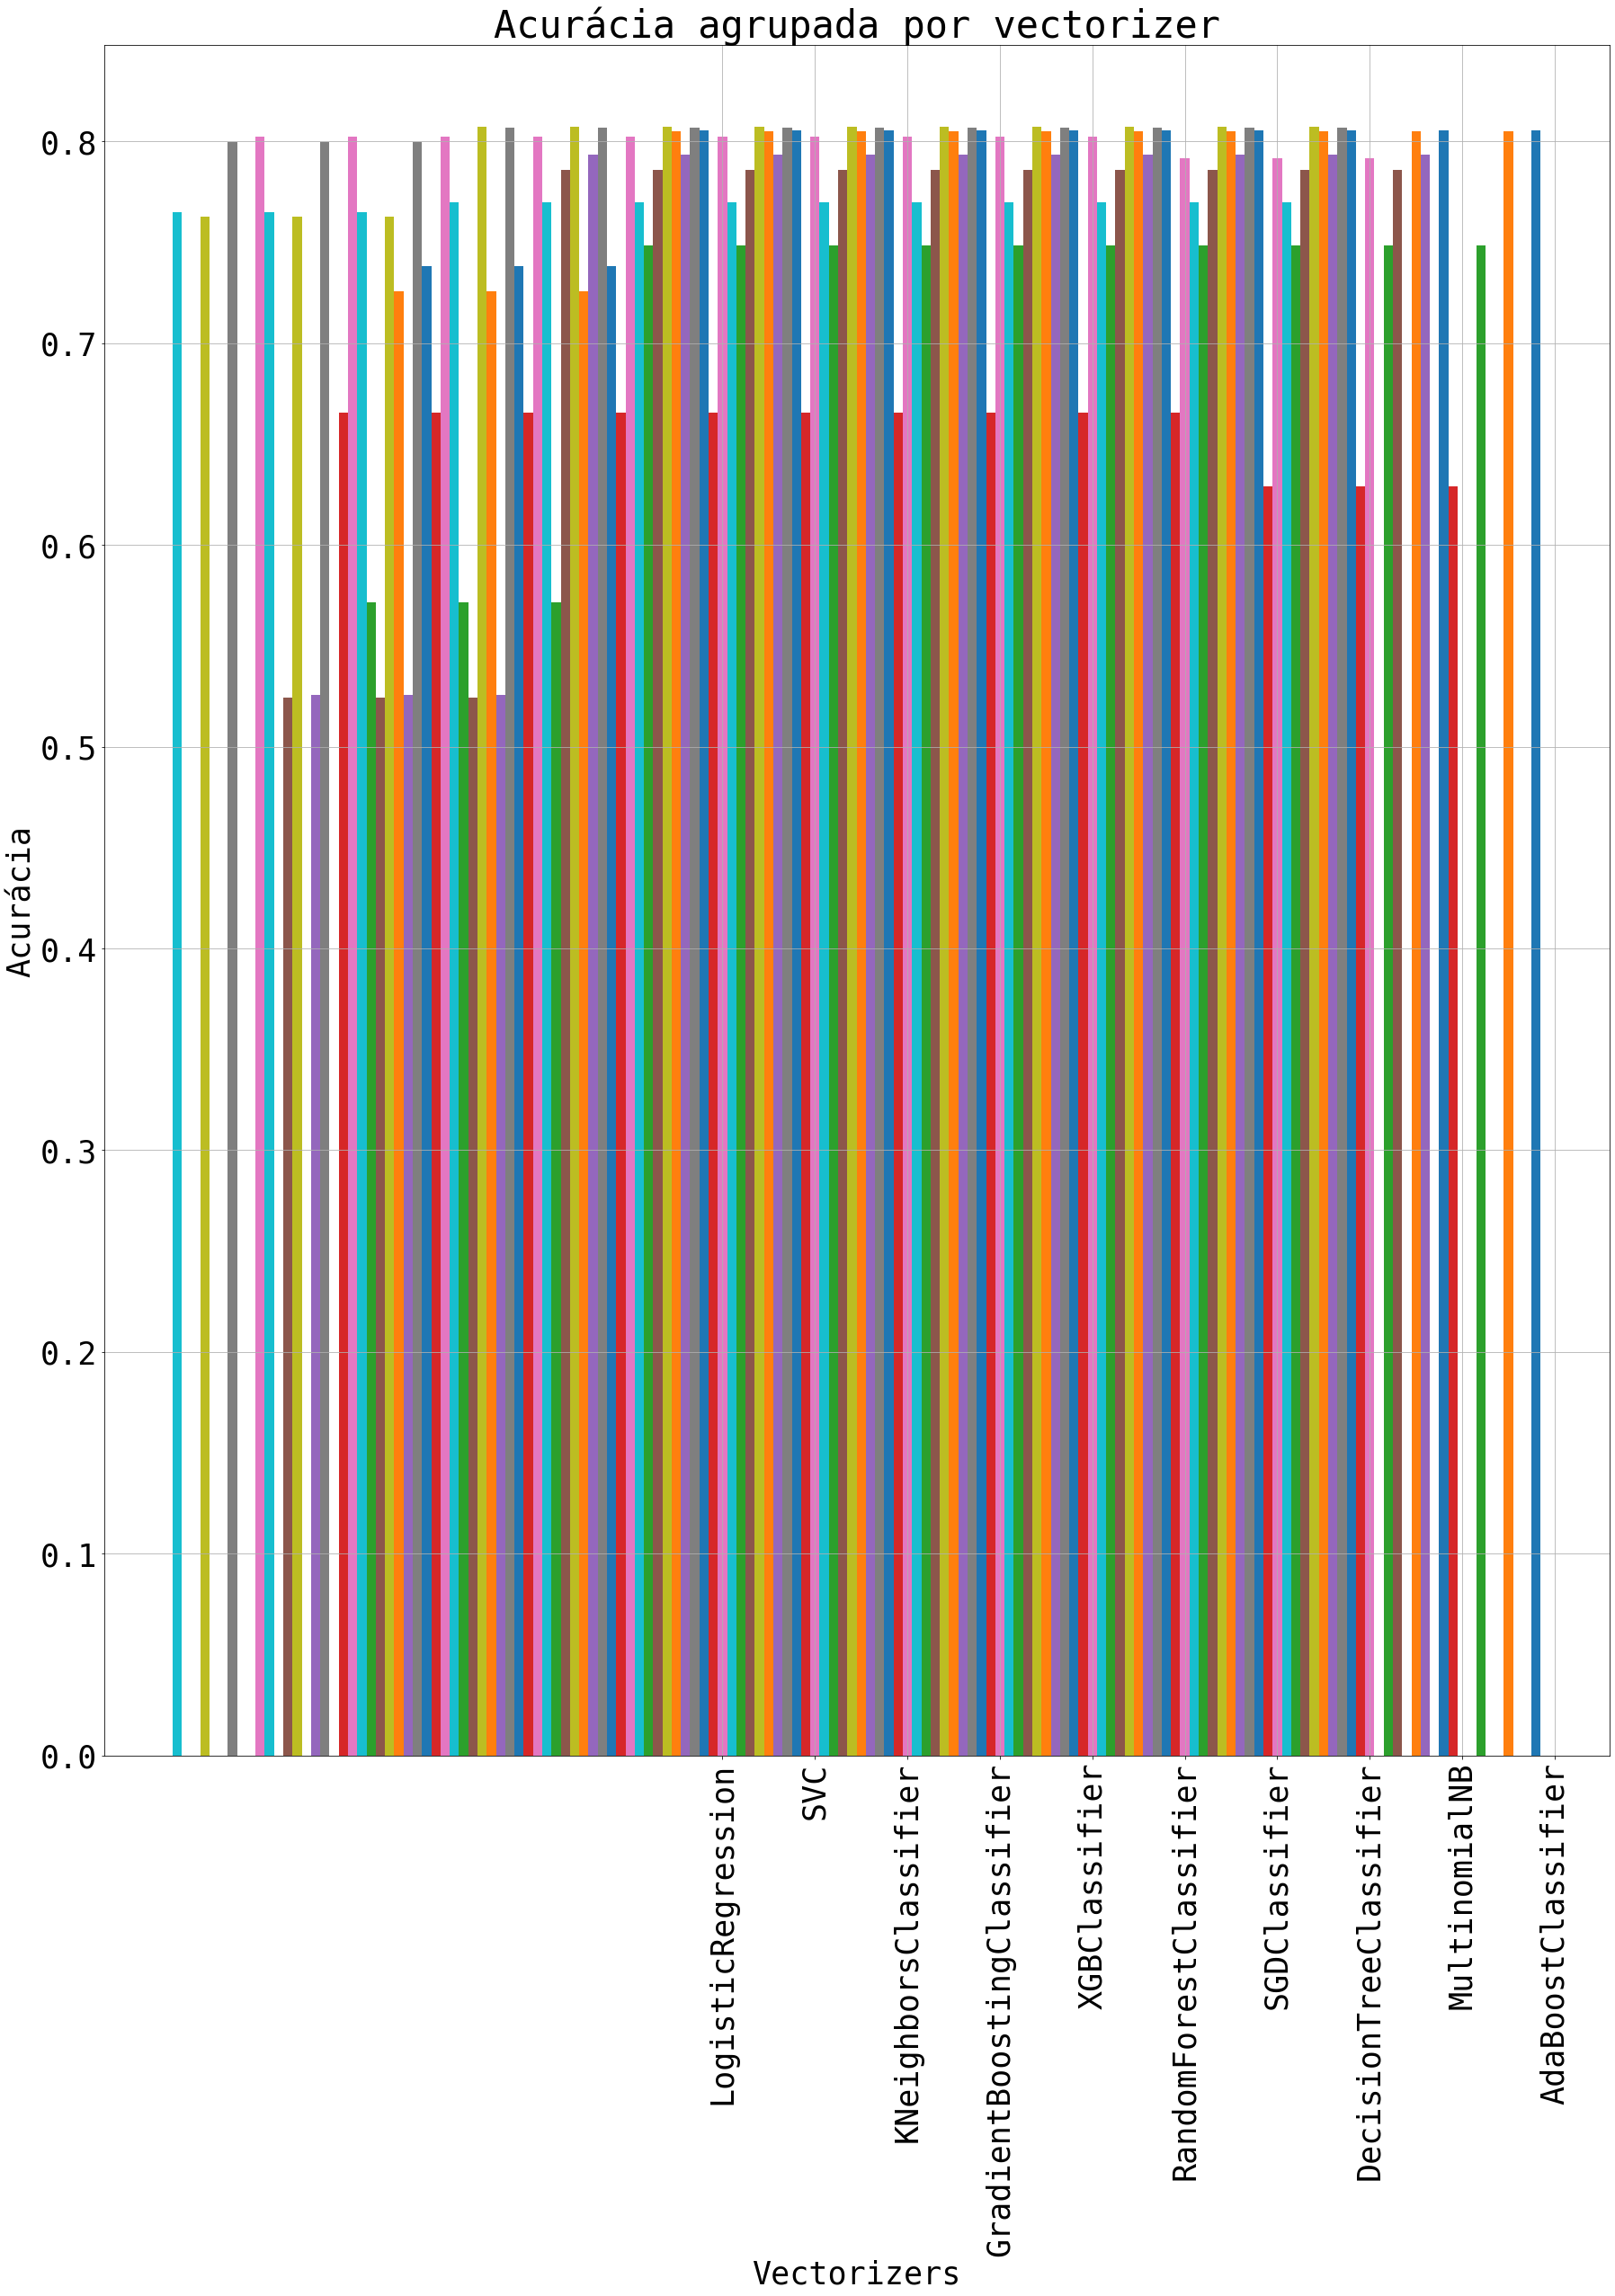

In [143]:
colors = {
        "0": "lightcoral",
        "1": "darkorange",
        "2": "olivedrab",
        "3": "paleturquise",
        "4": "slategrey",
        "5": "cornflowerblue",
        "6": "slateblue",
        "7": "rebeccapurple",
        "8": "crimson",
        "9": "pink",
        "10": "gold"
    }

x = np.arange(len(pd.Series(vectorizers))/2)
width = 0.1
  
labels = set()
models_count_vector = []
models_tfidf_vector = []
inicial_precision_bar = float(0.2)
add_precision_bar = float(0.3)

font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 35}
plt.rc('font', **font)
plt.rc('figure', figsize=(30, 35))
gg = 0

for m,v,a in zip (modelos, vectorizers, accs):
    
    if(str(v) == 'CountVectorizer()'):
        models_count_vector.append(a)
    else:
        models_tfidf_vector.append(a)
    
    index_parenteses = str(m).index("(")
    labels.add(str(m)[0:index_parenteses])

    plt.bar(x-inicial_precision_bar, a, width, color=colors.get(gg), label=str(v)[:15])
    inicial_precision_bar = round(inicial_precision_bar + add_precision_bar, 2)
    gg = gg+1
    
# plt.xticks(x, labels=['Count','Tf-idf'], rotation='vertical')
plt.xticks(x, labels, rotation='vertical')

plt.xlabel('Vectorizers')
plt.ylabel('Acurácia')
plt.title('Acurácia agrupada por vectorizer')
plt.legend
plt.grid(True)
plt.show()

TypeError: '<' not supported between instances of 'TfidfVectorizer' and 'CountVectorizer'

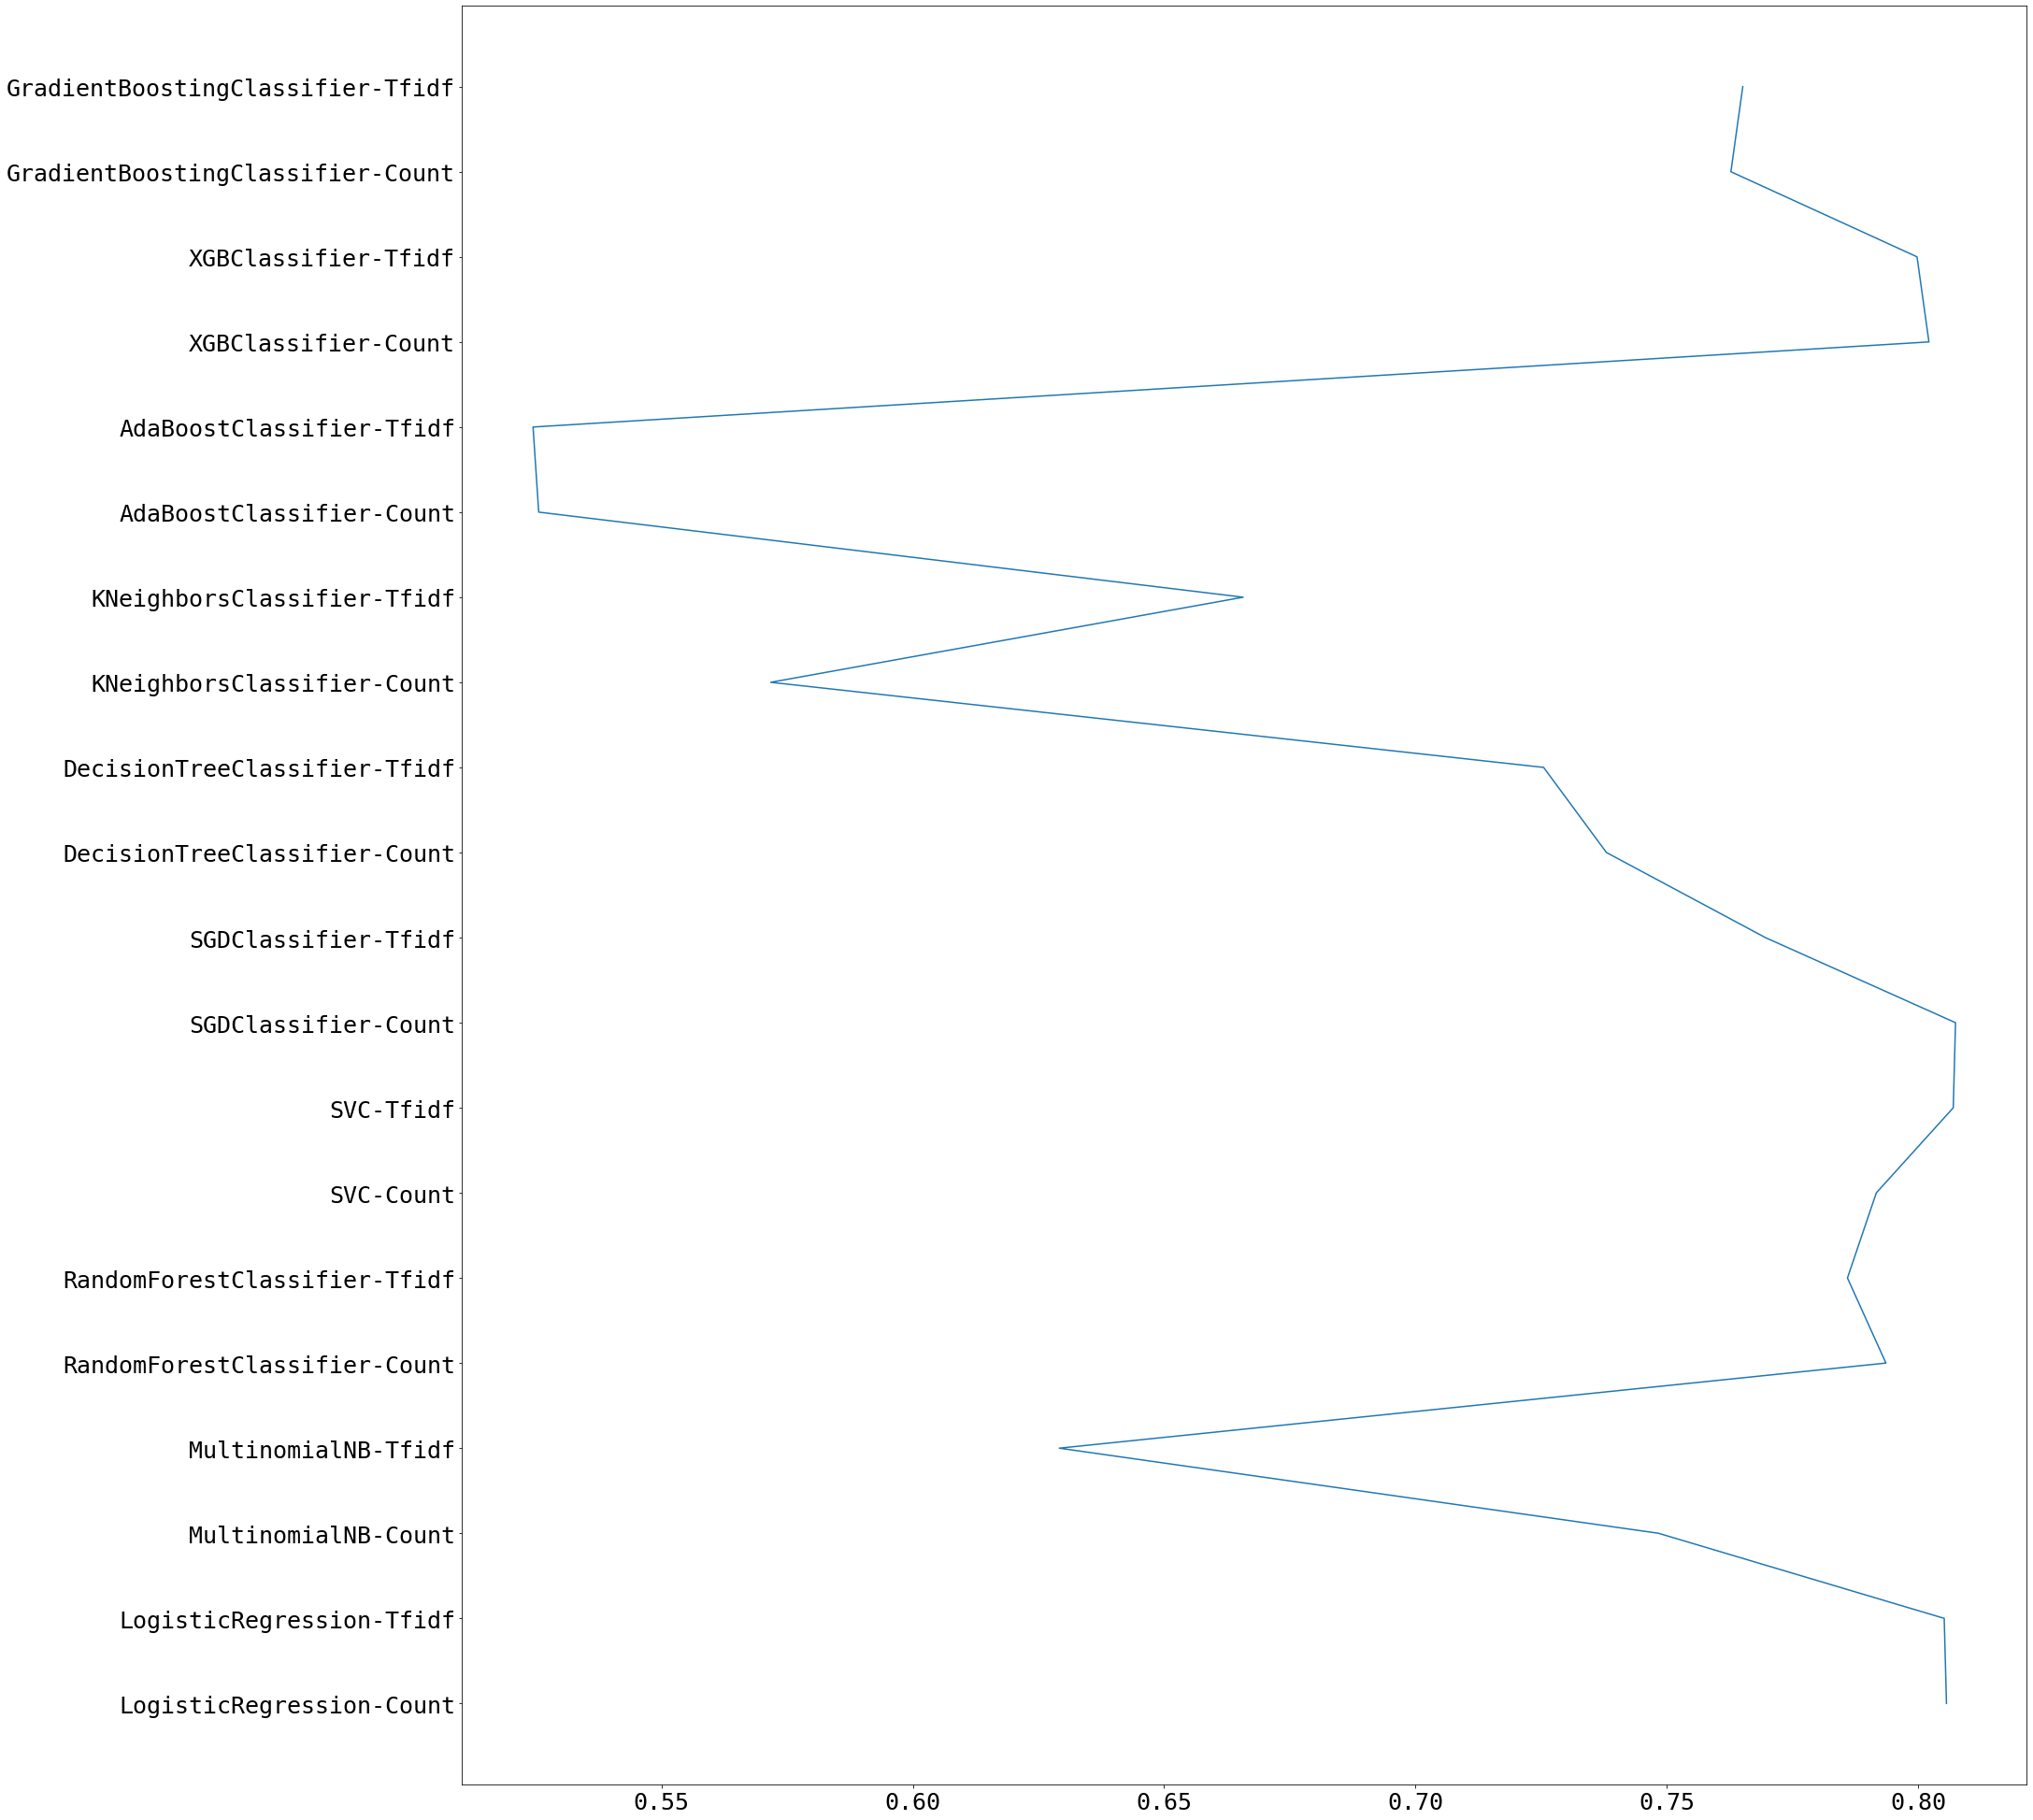

In [144]:
labels = []

font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 25}
plt.rc('font', **font)

for m,v in zip (modelos, vectorizers):
    index_parenteses = str(m).index("(")
    label = ('{}-{}'.format(str(m)[0:index_parenteses], str(v)[:5]))
    labels.append(label)

plt.plot(accs, labels)
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(vectorizers, labels, rotation='horizontal')
# plt.xticks(np.arange(len(vectorizers)), labels, rotation='horizontal')
# plt.yticks(accs, labels, rotation='horizontal')
# Pad margins so that markers don't get clipped by the axes
plt.margins(9.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)

plt.rc('font', **font)
plt.rc('figure', figsize=(30, 20))
plt.show()